# 0. Installations

In [5]:
!pip install nbimporter
!pip install scikit-learn

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import nbimporter
import backtesting
import classifications

# 1. Data Creation

In [7]:
file_path = "/home/jovyan/work/notebooks/IYH_holdings.csv"
iyh = pd.read_csv(file_path, skiprows=9)
initial_tickers = iyh['Ticker'][:-2].tolist()

In [8]:
# download adjusted close prices
start_date = "2014-01-01"
end_date = "2024-01-01"

prices = yf.download(initial_tickers, start=start_date, end=end_date)['Adj Close']

missing_tickers = prices.columns[prices.isnull().any()].tolist()
missing_tickers = missing_tickers + ['ENOV', 'USD']
print(f"Tickers with missing data: {missing_tickers}")

[*********************100%***********************]  110 of 110 completed

5 Failed downloads:
['SOLV', 'GRAL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1388552400, endDate = 1704085200")')
['XTSLA', 'WFFUT', 'IXCZ4']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Tickers with missing data: ['APLS', 'AVTR', 'CERT', 'CTLT', 'DOCS', 'ELAN', 'FTRE', 'GEHC', 'GRAL', 'INSP', 'ITCI', 'IXCZ4', 'MEDP', 'MRNA', 'NTRA', 'NVST', 'OGN', 'PEN', 'RARE', 'ROIV', 'RPRX', 'SHC', 'SOLV', 'TXG', 'VKTX', 'WFFUT', 'XTSLA', 'ENOV', 'USD']


In [9]:
# drop stocks that are too recent/missing data
prices = prices.drop(columns=missing_tickers)
tickers = [ticker for ticker in initial_tickers if ticker not in missing_tickers]
len(tickers)

81

In [10]:
# generate stock pairs
from itertools import combinations
pairs = list(combinations(tickers, 2))
pairs_df = pd.DataFrame(pairs, columns=['Ticker 1', 'Ticker 2'])

In [11]:
# save to csv file
prices.to_csv("prices.csv")
prices.head()

Ticker,A,ABBV,ABT,ACHC,ALGN,ALNY,AMED,AMGN,AZTA,BAX,...,UNH,UTHR,VEEV,VRTX,VTRS,WAT,WST,XRAY,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,36.747051,33.291309,30.904150,47.049999,56.959999,63.860001,14.42,85.420166,8.919321,30.985807,...,63.013298,110.900002,32.330002,73.830002,36.573864,99.220001,46.143192,43.370045,82.166466,29.830694
2014-01-03,37.211208,33.496258,31.235586,47.770000,57.169998,63.139999,14.55,84.439079,9.004923,31.035074,...,63.461102,111.309998,35.169998,73.449997,36.694118,98.040001,46.560265,43.578037,82.522789,29.544920
2014-01-06,37.028156,32.272968,31.647860,48.380001,59.900002,61.070000,14.56,83.708794,8.987799,31.088816,...,62.734409,111.379997,34.860001,75.500000,36.298996,98.389999,46.304344,43.315807,83.057259,29.480392
2014-01-07,37.557686,32.337013,31.405350,48.480000,61.360001,62.310001,14.96,85.884880,9.056278,31.254509,...,64.652634,110.430000,34.340000,74.489998,36.917435,100.379997,46.655064,43.984974,84.714127,29.591013
2014-01-08,38.172203,32.253761,31.688284,49.320000,60.730000,63.680000,14.88,85.479172,8.782364,31.357517,...,63.900524,109.699997,34.169998,75.230003,38.420593,100.480003,47.328056,44.066357,86.789635,29.259150


## Exploratory Data Analysis

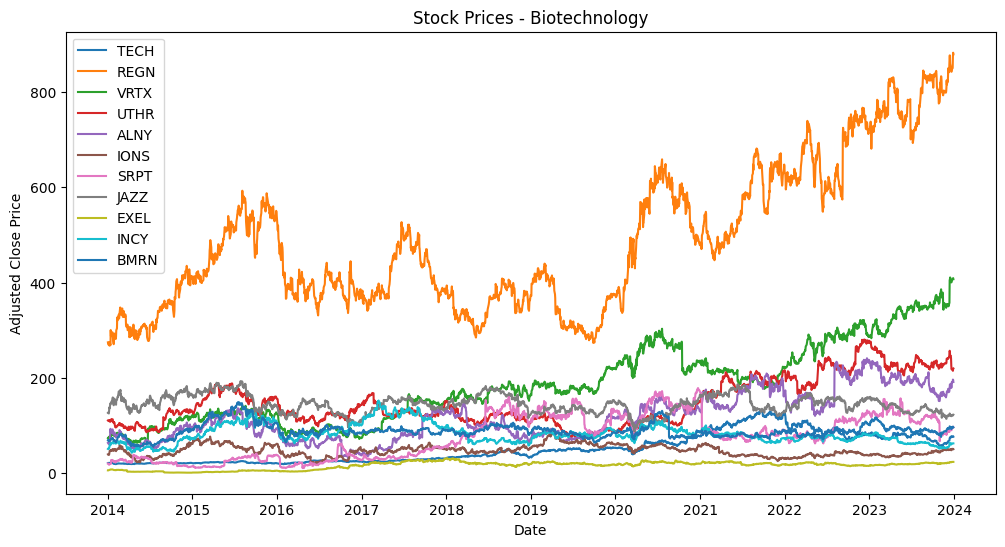

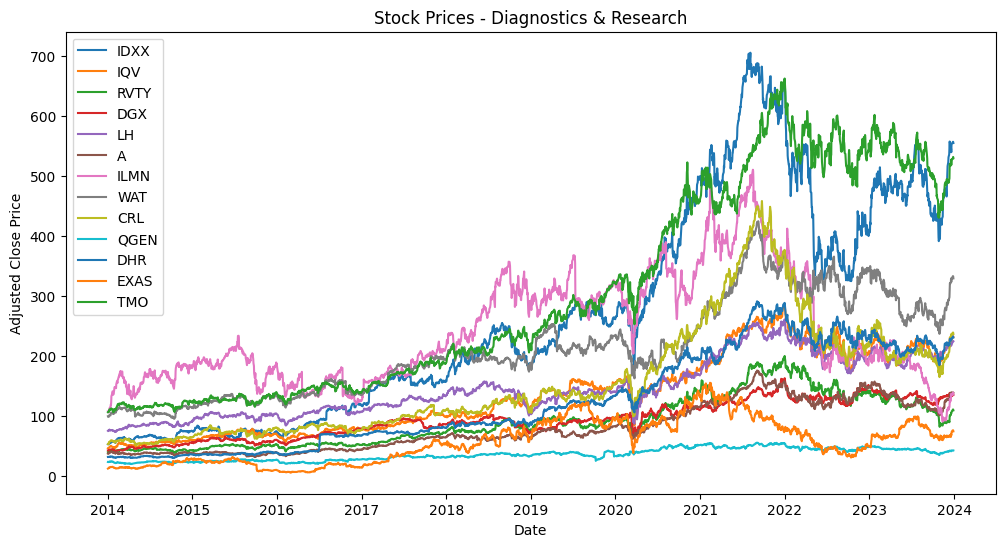

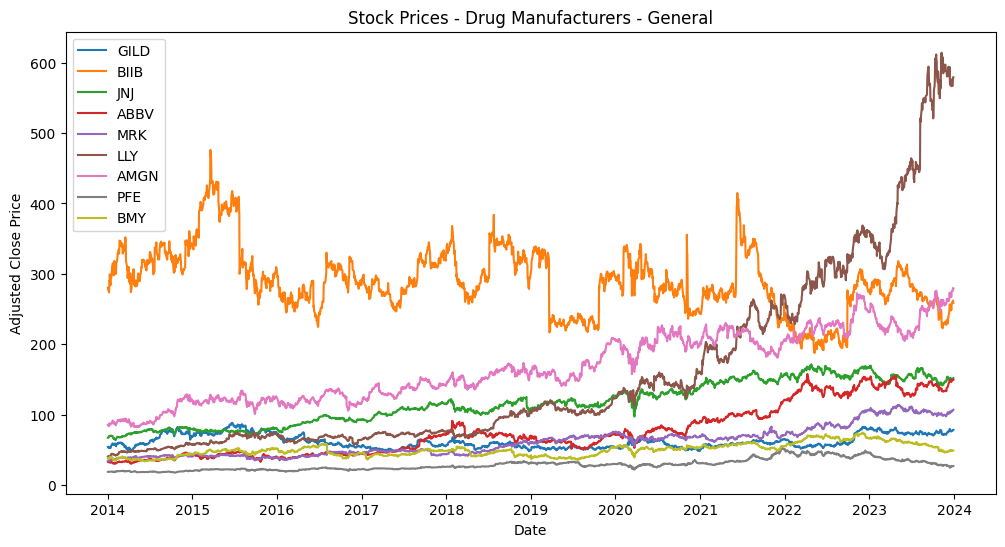

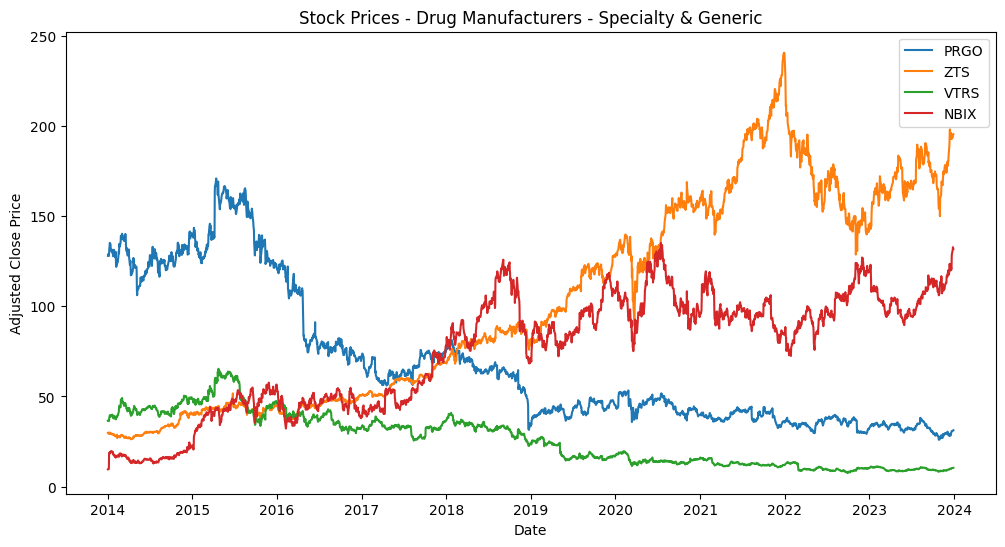

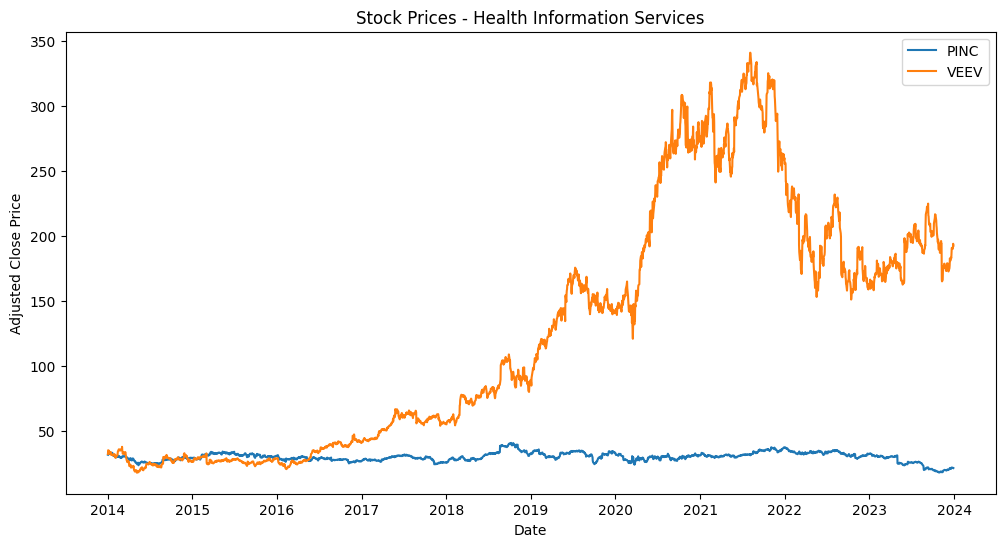

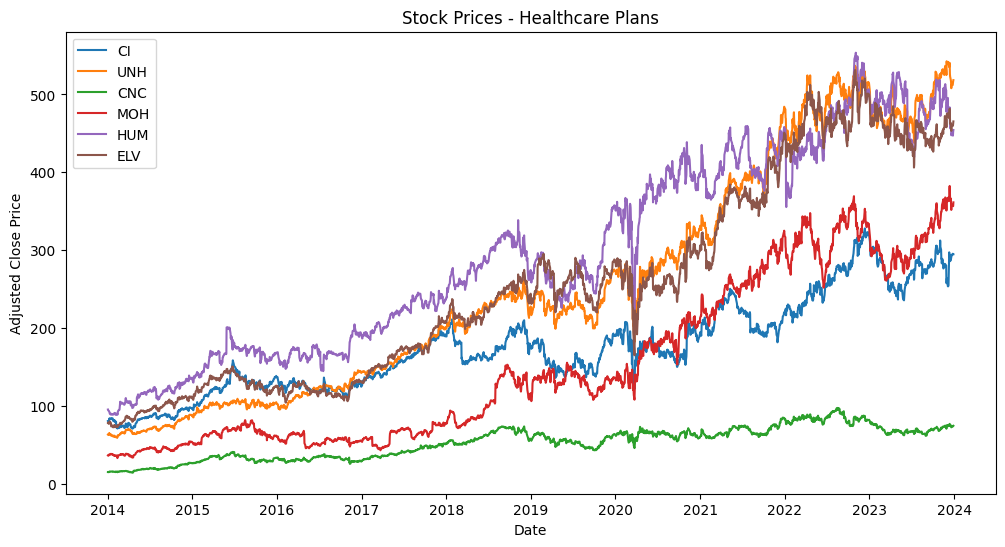

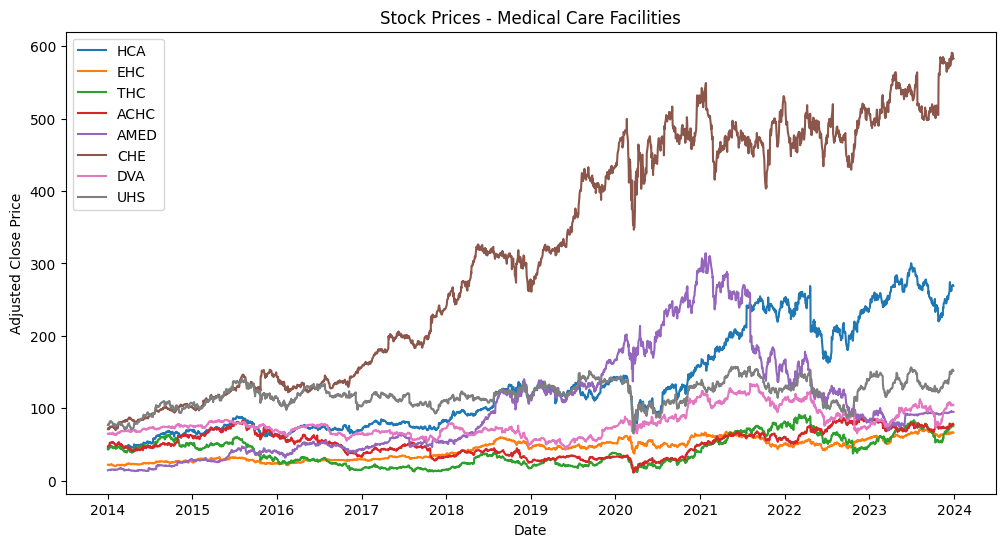

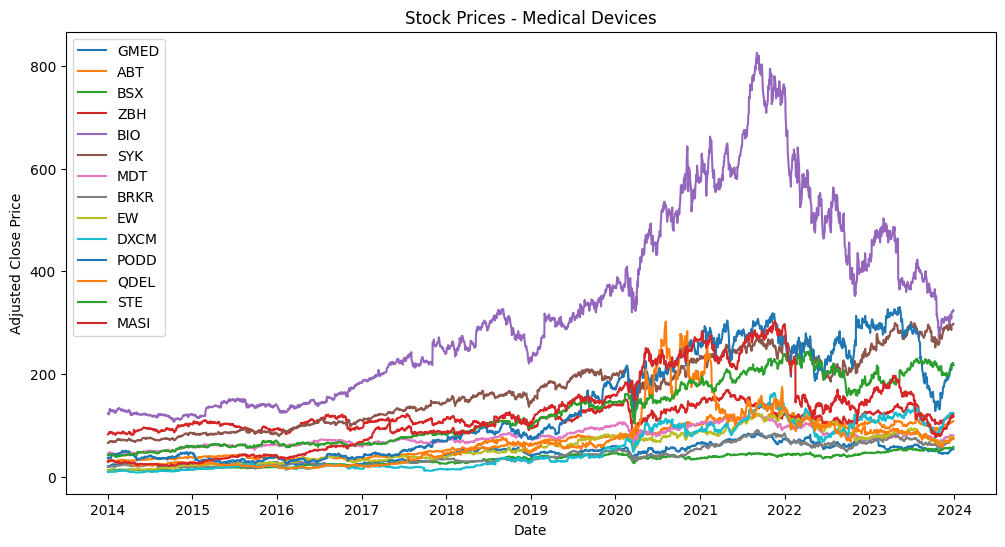

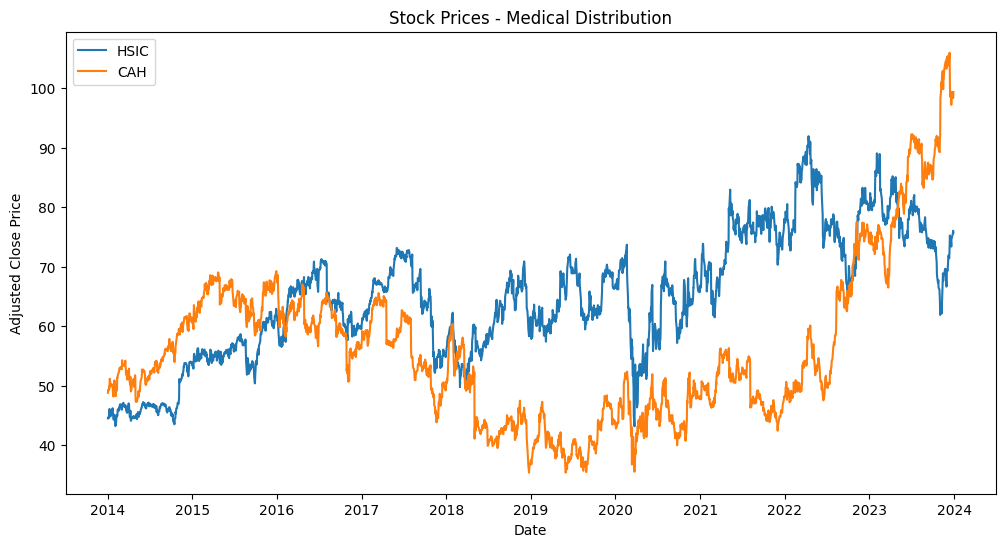

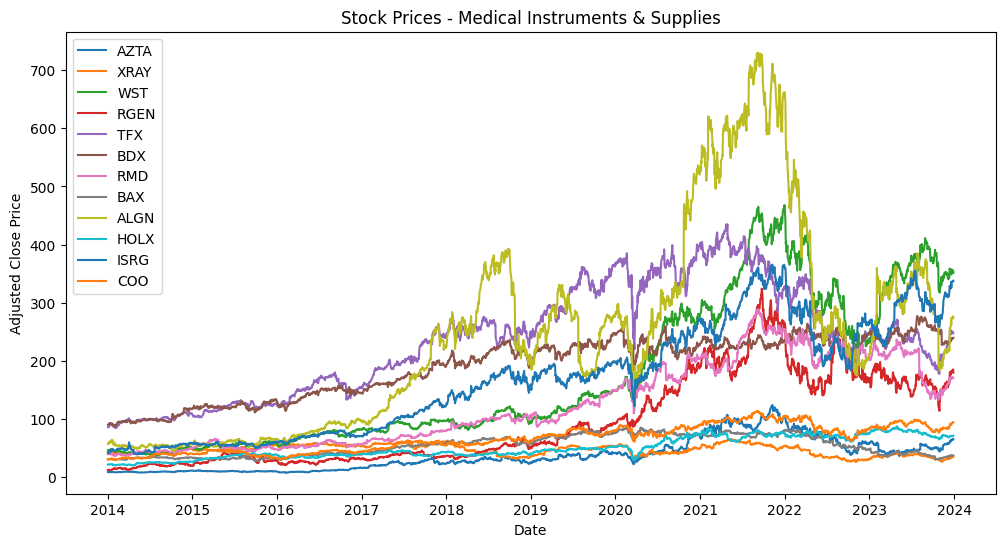

In [13]:
# fetch sector and industry information
industry_info = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    industry_info[ticker] = {'Ticker': stock.ticker, 'Industry': stock.info.get('industry', 'Unknown')}

# group tickers by industry
industry_df = pd.DataFrame.from_dict(industry_info, orient='index')
industry_df = industry_df.sort_values(by='Industry')
industry_df.to_csv("industry_mapping.csv")
industry_groups = industry_df.groupby("Industry")['Ticker'].apply(list).to_dict()

for industry, industry_tickers in industry_groups.items():
    if industry != "Error" and industry_tickers:  # skip errors and empty groups
        plt.figure(figsize=(12, 6))
        for ticker in industry_tickers:
            if ticker in prices.columns:  # Ensure ticker exists in the dataset
                plt.plot(prices[ticker], label=ticker)
        plt.title(f"Stock Prices - {industry}")
        plt.xlabel("Date")
        plt.ylabel("Adjusted Close Price")
        plt.legend()
        plt.show()

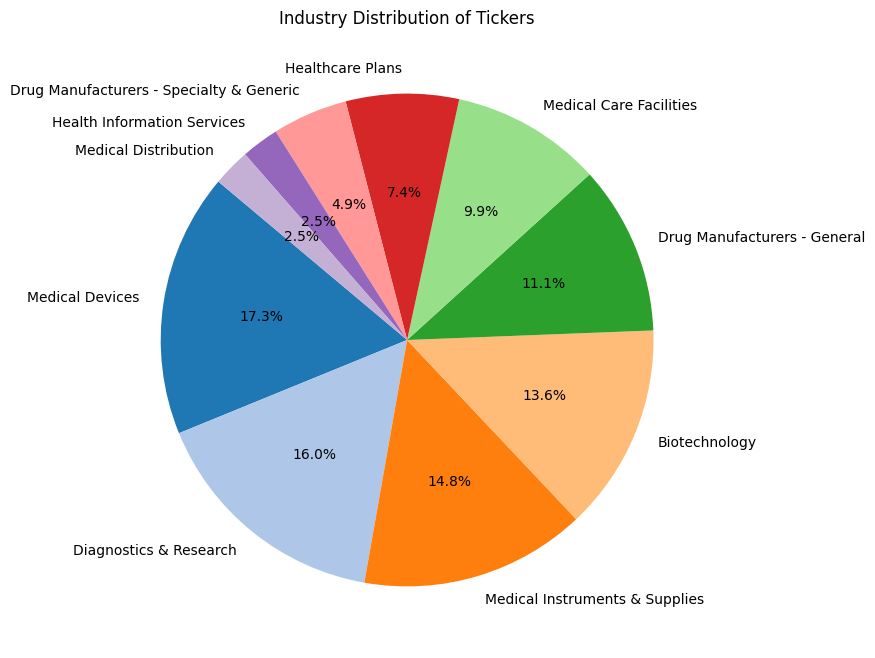

In [14]:
industry_counts = industry_df['Industry'].value_counts()
# pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    industry_counts,
    labels=industry_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Industry Distribution of Tickers")
plt.show()

# 2. Labeling

### Spread Dynamics

In [17]:
# define functions for ADF and Johansen tests
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def compute_spread(prices1, prices2): # compute spread using linear reg
    lr = LinearRegression()
    lr.fit(prices2.values.reshape(-1, 1), prices1.values)
    beta = lr.coef_[0]
    spread = prices1 - beta * prices2
    return spread

def johansen_test(prices1, prices2, det_order=0, k_ar_diff=1): # apply johansen test for cointegration
    """Apply Johansen test for cointegration."""
    data = pd.concat([prices1, prices2], axis=1).dropna()
    result = coint_johansen(data.values, det_order, k_ar_diff)
    return result.lr1[0], result.cvt[0, 1]  # trace statistic, 5% critical value

def adf_test(series): # ADF test to check for stationarity
    result = adfuller(series, autolag='AIC')
    return result[1]  # return p-val

In [18]:
# compute features and apply stationary tests
results = []

for stock1, stock2 in pairs:
    prices1 = prices[stock1]
    prices2 = prices[stock2]
    
    spread = compute_spread(prices1, prices2)
    adf_pvalue = adf_test(spread)
    johansen_stat, johansen_crit = johansen_test(prices1, prices2)
    
    # determine mean-reversion based on both tests
    adf_stationary = adf_pvalue < 0.05
    johansen_stationary = johansen_stat > johansen_crit
    
    results.append({
        'pair': (stock1, stock2),
        'adf_pvalue': adf_pvalue,
        'johansen_stat': johansen_stat,
        'johansen_crit': johansen_crit,
        'adf_stationary': adf_stationary,
        'johansen_stationary': johansen_stationary,
        'mean_reverting': adf_stationary and johansen_stationary
    })

results_df = pd.DataFrame(results)

In [19]:
results_df

,pair,adf_pvalue,johansen_stat,johansen_crit,adf_stationary,johansen_stationary,mean_reverting
0,"(LLY, UNH)",0.984,10.003,15.494,False,False,False
1,"(LLY, JNJ)",0.994,14.252,15.494,False,False,False
2,"(LLY, ABBV)",0.591,12.059,15.494,False,False,False
3,"(LLY, MRK)",0.446,13.253,15.494,False,False,False
4,"(LLY, ABT)",0.989,9.671,15.494,False,False,False
...,...,...,...,...,...,...,...
3235,"(AMED, QDEL)",0.009,18.495,15.494,True,True,True
3236,"(AMED, PINC)",0.435,13.446,15.494,False,False,False
3237,"(AZTA, QDEL)",0.125,18.985,15.494,False,True,False
3238,"(AZTA, PINC)",0.716,13.871,15.494,False,False,False


In [20]:
results_df.to_csv("pair_stationarity_results.csv", index=False)
print("Results saved to 'pair_stationarity_results.csv'")

Results saved to 'pair_stationarity_results.csv'


In [21]:
mean_reverting_pairs = results_df[results_df['mean_reverting'] == True]
print(f"Number of mean-reverting pairs: {len(mean_reverting_pairs)}")
mean_reverting_pairs.head(25)

Number of mean-reverting pairs: 337


,pair,adf_pvalue,johansen_stat,johansen_crit,adf_stationary,johansen_stationary,mean_reverting
81,"(UNH, ABBV)",2.062e-03,18.371,15.494,True,True,True
95,"(UNH, ELV)",7.427e-03,22.892,15.494,True,True,True
108,"(UNH, ALNY)",8.122e-03,16.656,15.494,True,True,True
142,"(UNH, HSIC)",4.576e-02,16.570,15.494,True,True,True
165,"(JNJ, DHR)",3.038e-03,17.890,15.494,True,True,True
181,"(JNJ, IQV)",9.318e-03,18.315,15.494,True,True,True
185,"(JNJ, HUM)",2.294e-04,21.935,15.494,True,True,True
188,"(JNJ, CNC)",2.903e-02,15.978,15.494,True,True,True
192,"(JNJ, WAT)",1.488e-03,17.369,15.494,True,True,True
199,"(JNJ, DGX)",7.674e-05,24.058,15.494,True,True,True


# 3. Feature Engineering

In [24]:
# DATA PREPROCESSING
# calculate annualized returns of financial time series data
returns = prices.pct_change(fill_method=None).mean()*252
returns = pd.DataFrame(returns)
returns.columns = ['returns']

# calculate volatility
returns['volatility'] = prices.pct_change(fill_method=None).std()*np.sqrt(252)

# preprocess
scale = StandardScaler().fit(returns)
scaled_data = pd.DataFrame(scale.fit_transform(returns),columns = returns.columns, index = returns.index)
scaled_data.T

Ticker,A,ABBV,ABT,ACHC,ALGN,ALNY,AMED,AMGN,AZTA,BAX,...,UNH,UTHR,VEEV,VRTX,VTRS,WAT,WST,XRAY,ZBH,ZTS
returns,-0.127,0.071,-0.277,-0.368,0.876,1.001,0.998,-0.314,1.317,-1.344,...,0.656,-0.514,0.838,0.626,-2.393,-0.239,0.653,-1.637,-1.072,0.43
volatility,-0.683,-0.636,-0.941,0.887,1.166,2.244,0.773,-0.826,1.206,-0.869,...,-0.760,0.133,0.637,0.383,0.388,-0.618,-0.497,-0.435,-0.601,-0.73


## 3.0 Industry Mapping
Most of the work sorting was done above.

In [49]:
# prepare a reverse mapping of stock to its industry
stock_to_industry = industry_df.set_index('Ticker')['Industry'].to_dict()

## 3.1 Correlation

In [25]:
# correlation coefficients (flattened)
correlation_matrix = prices.corr()

correlations = [(pair[0], pair[1], correlation_matrix.loc[pair[0], pair[1]]) for pair in pairs]

correlation_df = pd.DataFrame(correlations, columns=['stock1', 'stock2', 'correlation'])

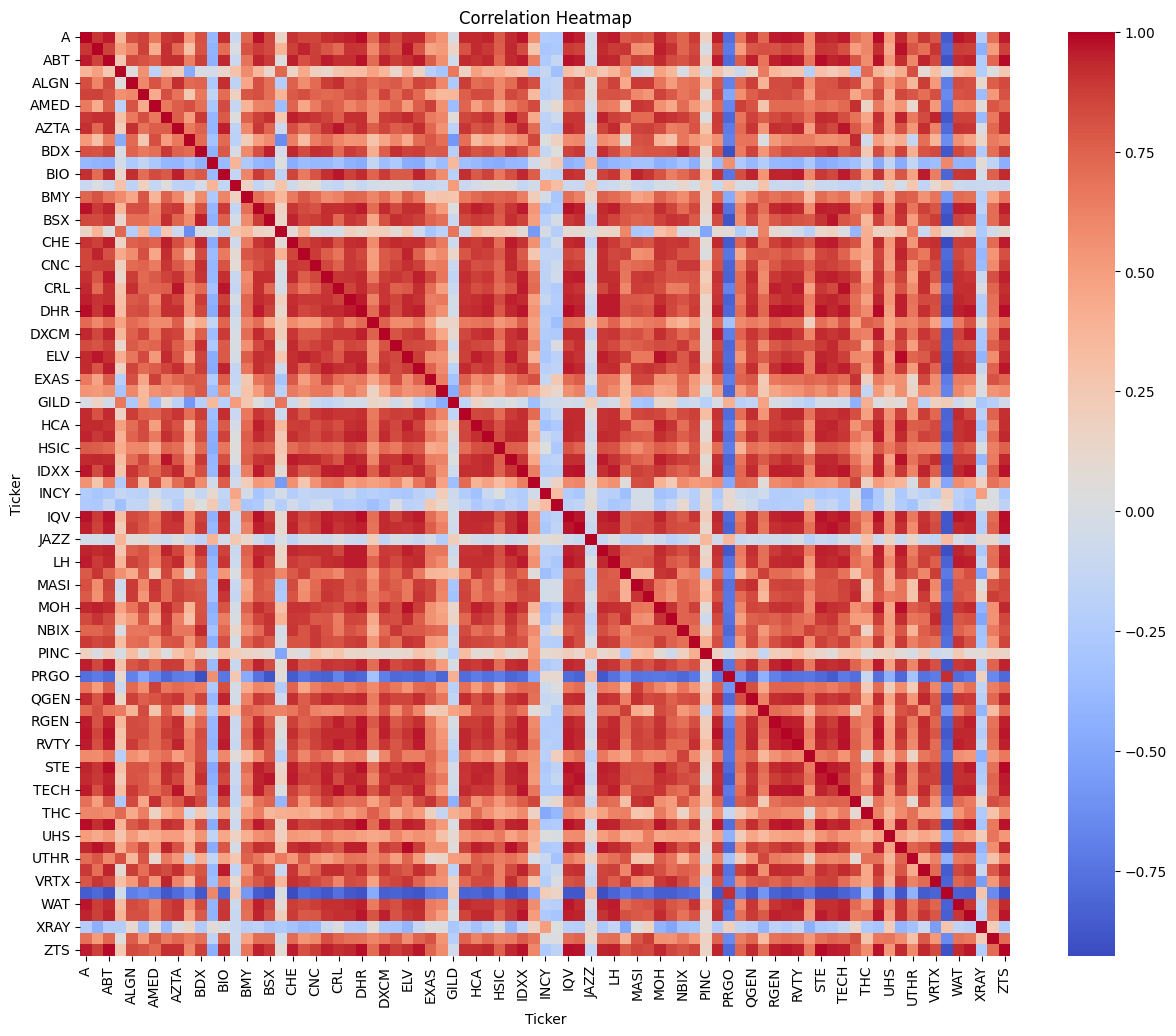

In [26]:
plt.figure(figsize=(15, 12))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap")  # Add a title
plt.show()

## 3.2 K Means

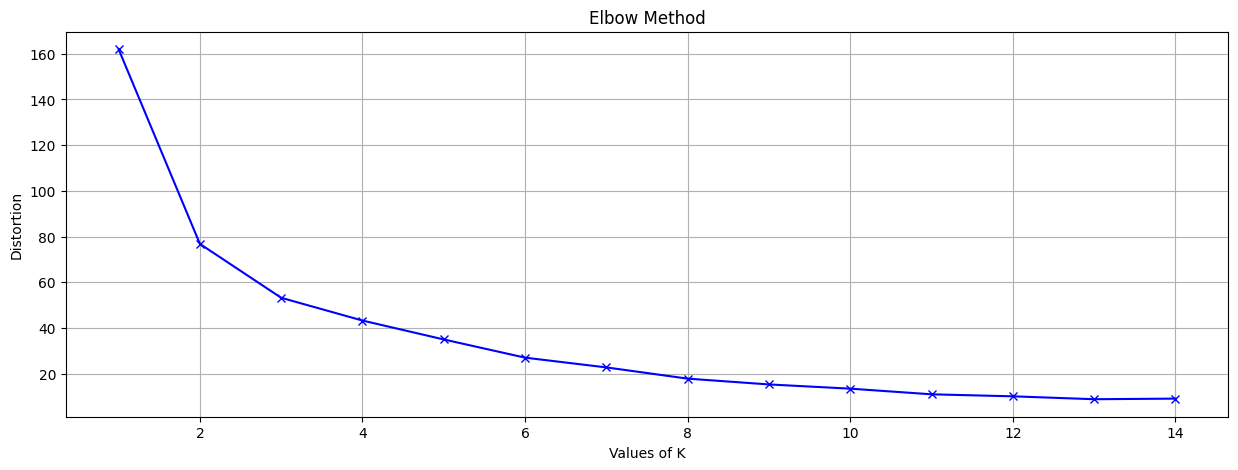

In [31]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

K = range(1,15)
distortions = []

for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [32]:
!pip install kneed -q
from kneed import KneeLocator
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

np.int64(3)

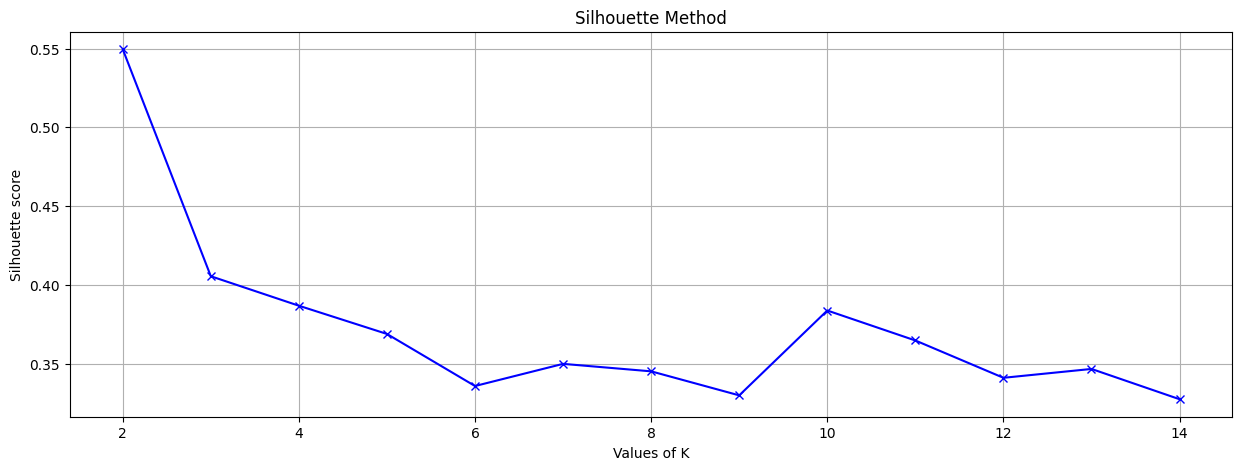

Suggested number of clusters:  6


In [33]:
from sklearn.metrics import silhouette_score
# k starts from 2 for silhouette method
K = range(2,15)
silhouettes = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(scaled_data)
    silhouettes.append(silhouette_score(scaled_data, kmeans.labels_))

fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

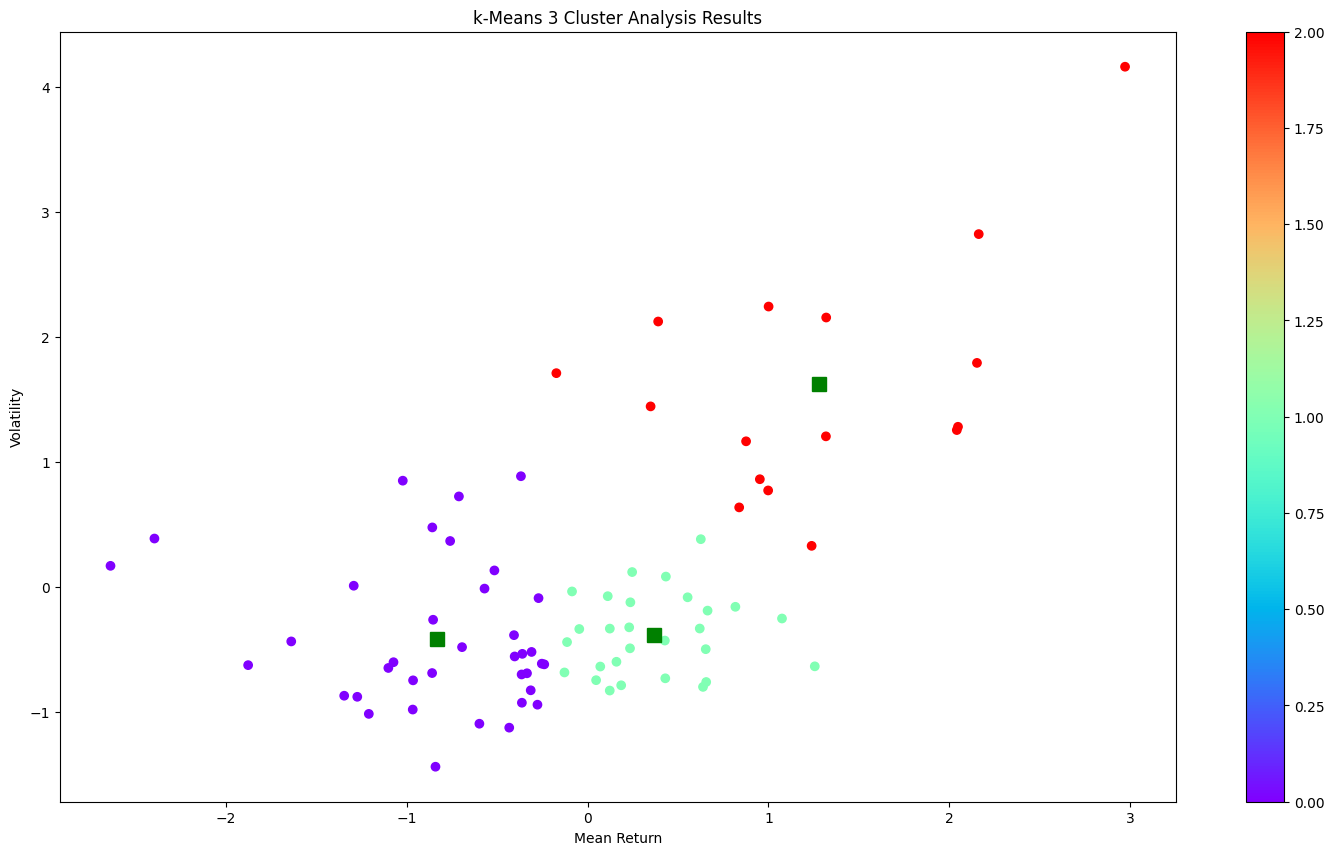

In [146]:
k_means_3 = KMeans(n_clusters=3)
k_means_3.fit(scaled_data)
prediction_3 = k_means_3.predict(scaled_data)
scaled_data['Cluster'] = k_means_3.labels_
kmeans_3_df = scaled_data['Cluster']
kmeans_3_df = pd.DataFrame(kmeans_3_df)

centroids = k_means_3.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(scaled_data.iloc[:,0],scaled_data.iloc[:,1], c=k_means_3.labels_, cmap="rainbow", label = scaled_data.index)
ax.set_title('k-Means 3 Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

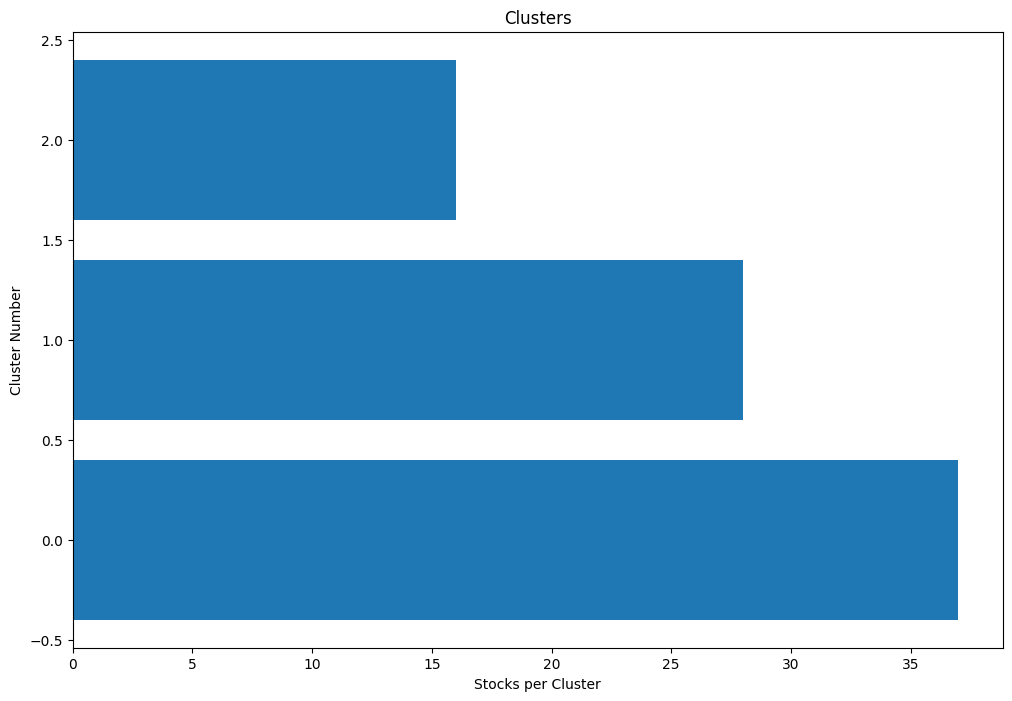

In [147]:
clustered_series_3 = pd.Series(index=scaled_data.index, data=k_means_3.labels_.flatten())
clustered_series_all_3 = pd.Series(index=scaled_data.index, data=k_means_3.labels_.flatten())
clustered_series_3 = clustered_series_3[clustered_series_3 != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series_3.value_counts())),clustered_series_3.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

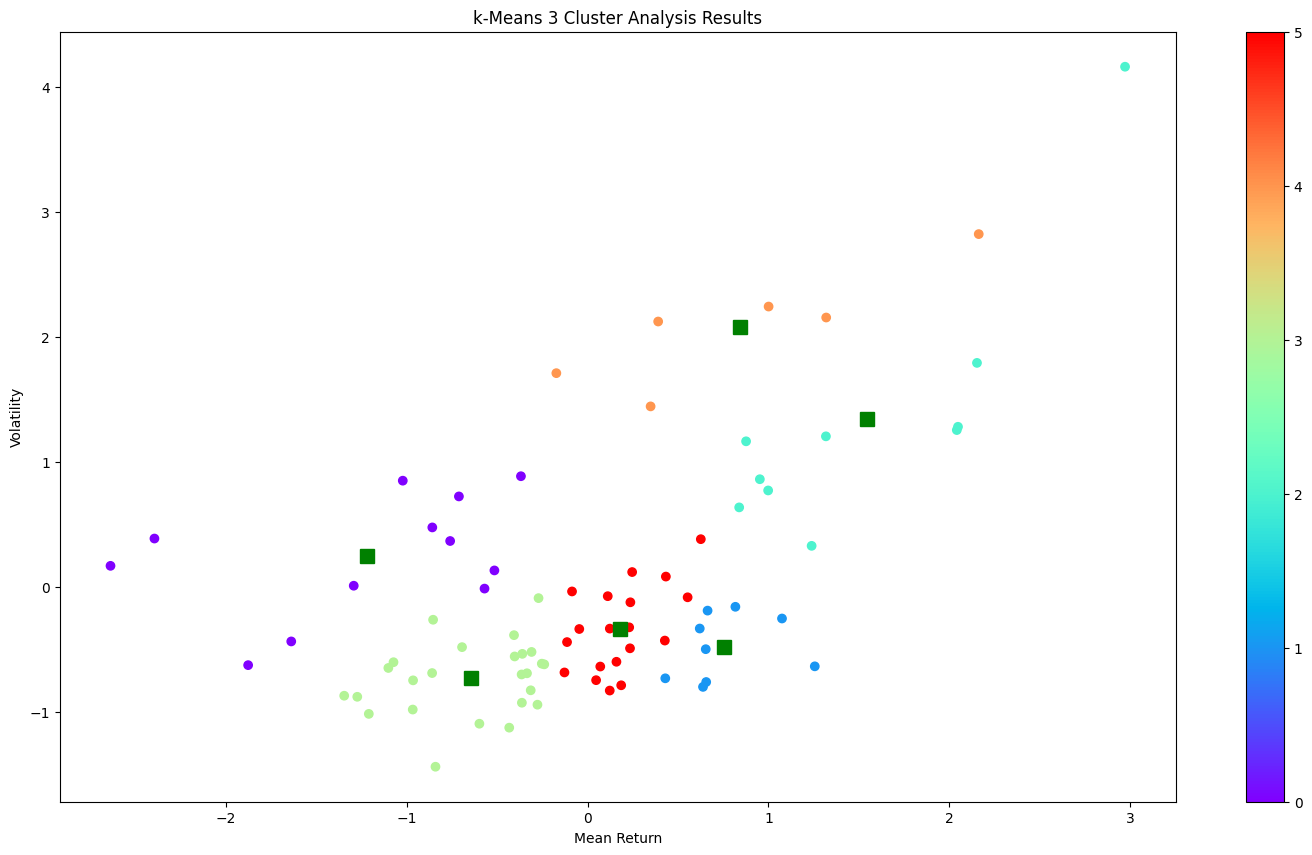

In [156]:
k_means_6 = KMeans(n_clusters=6)
k_means_6.fit(scaled_data)
prediction = k_means_6.predict(scaled_data)
scaled_data['Cluster'] = k_means_6.labels_
kmeans_6_df = scaled_data['Cluster']
kmeans_6_df = pd.DataFrame(kmeans_6_df)

centroids = k_means_6.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(scaled_data.iloc[:,0],scaled_data.iloc[:,1], c=k_means_6.labels_, cmap="rainbow", label = scaled_data.index)
ax.set_title('k-Means 3 Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

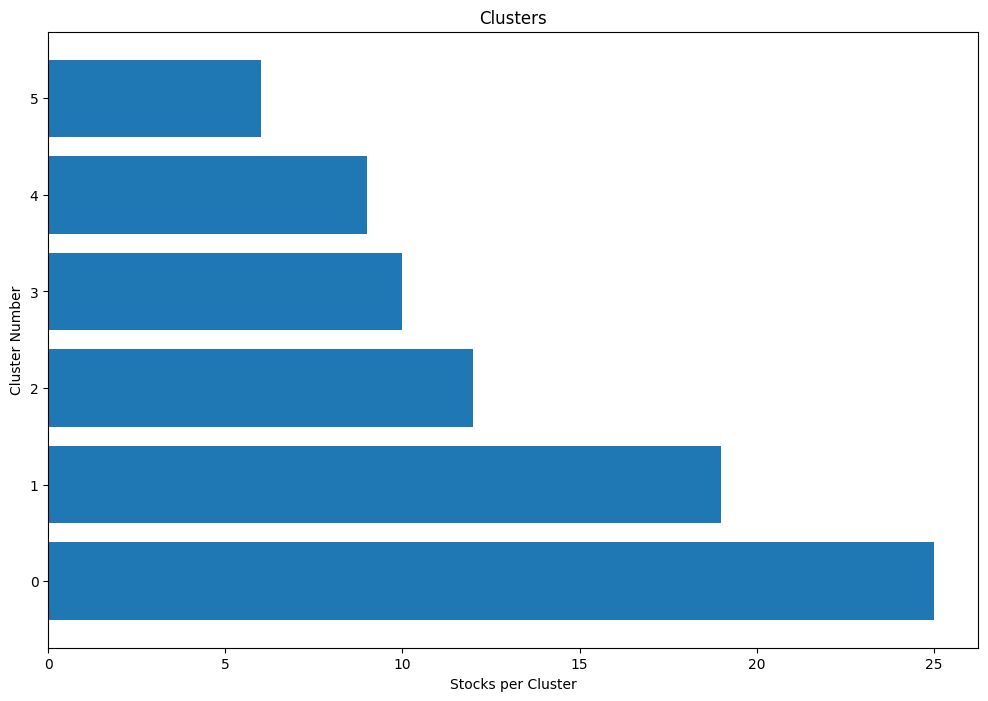

In [157]:
clustered_series_6 = pd.Series(index=scaled_data.index, data=k_means_6.labels_.flatten())
clustered_series_all_6 = pd.Series(index=scaled_data.index, data=k_means_6.labels_.flatten())
clustered_series_6 = clustered_series_6[clustered_series_6 != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series_6.value_counts())),clustered_series_6.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

Note that every run produces different cluster sets, which slightly alters the final result of classifiers at the later step.

## 3.3 Keyword Feature

In [36]:
!pip install nltk -q
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
def preprocess_summary(summary):
    stop_words = set(stopwords.words('english'))
    summary = re.sub(r'[^\w\s]', '', summary.lower())  # Remove punctuation and lowercase
    tokens = [word for word in summary.split() if word not in stop_words]
    return tokens

def preprocess_summary(summary):
    stop_words = set(stopwords.words('english'))
    summary = re.sub(r'[^\w\s]', '', summary.lower())  # Remove punctuation and lowercase
    tokens = [word for word in summary.split() if word not in stop_words]
    return tokens

In [39]:
# fetch summaries and preprocess
stock_summaries = {}

for ticker in tickers:
    try:
        summary = yf.Ticker(ticker).info.get('longBusinessSummary', '')
        if summary:
            stock_summaries[ticker] = preprocess_summary(summary)
        else:
            stock_summaries[ticker] = [] 
    except Exception as e:
        print(f"Error fetching summary for {ticker}: {e}")
        stock_summaries[ticker] = []

# convert to df
stock_summaries_str = {ticker: ' '.join(tokens) for ticker, tokens in stock_summaries.items()}
summaries_df = pd.DataFrame.from_dict(stock_summaries_str, orient='index')
summaries_df.columns = ['keywords']
summaries_df.to_csv('summaries_df.csv')

def count_overlap(keywords_a, keywords_b):
    return len(set(keywords_a).intersection(set(keywords_b)))

overlap_df = []
for pair in pairs:
    stock_a, stock_b = pair
    overlap_count = count_overlap(
        summaries_df.loc[stock_a, 'keywords'], summaries_df.loc[stock_b, 'keywords']
    )
    overlap_df.append({'pair': pair, 'keyword_overlap': overlap_count})
    
# insert into classifications df as feature
overlap_df = pd.DataFrame(overlap_df)

In [43]:
overlap_df.head()

,pair,keyword_overlap
0,"(LLY, UNH)",30
1,"(LLY, JNJ)",29
2,"(LLY, ABBV)",31
3,"(LLY, MRK)",32
4,"(LLY, ABT)",27


## 3.4 Earnings Growth Differential

In [44]:
# fetch revenue data
earnings_data = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    financials = stock.financials  # quarterly financial data
    if financials is not None and not financials.empty:
        if "Total Revenue" in financials.index:
            earnings_data[ticker] = financials.loc["Total Revenue"]
        else:
            print(f"No revenue data for {ticker}")
    else:
        print(f"No financial data for {ticker}")

if earnings_data:
    earnings_df = pd.DataFrame(earnings_data)
    aligned_earnings = earnings_df.ffill(axis=0)  # forward-fill to handle missing values
else:
    print("No financial data available for any ticker.")

# yoy earnings growth rates
earnings_growth = aligned_earnings.pct_change().fillna(0)
rolling_growth = earnings_growth.rolling(window=3, min_periods=1).mean()
rolling_growth_yearly = rolling_growth[rolling_growth.index.month == 12]
rolling_growth_yearly = rolling_growth_yearly.tail(3)
growth_summary = rolling_growth_yearly.mean(axis=0)  # avg growth for each ticker
growth_std_dev = rolling_growth_yearly.std(axis=0)
growth_stats = pd.DataFrame({
    'Average Growth': growth_summary,
    'Growth Std Dev': growth_std_dev
})

/tmp/ipykernel_354/2375012298.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aligned_earnings = earnings_df.ffill(axis=0)  # forward-fill to handle missing values


In [46]:
growth_diff_df = []

# loop through each pair to calculate growth differential
for pair in pairs:
    stock_a, stock_b = pair
    growth_diff = growth_stats.loc[stock_a, 'Average Growth'] - growth_stats.loc[stock_b, 'Average Growth']
    growth_diff_df.append({'pair': pair, 'growth_diff': growth_diff})

growth_diff_df = pd.DataFrame(growth_diff_df)

In [48]:
growth_diff_df.head()

,pair,growth_diff
0,"(LLY, UNH)",-0.003
1,"(LLY, JNJ)",0.036
2,"(LLY, ABBV)",0.018
3,"(LLY, MRK)",-0.005
4,"(LLY, ABT)",0.020


## Putting it all together

In [163]:
# Precomputed data
# correlation_matrix = prices.corr()  # Precomputed correlation matrix
stock_to_cluster_3 = kmeans_3_df['Cluster'].to_dict()  # Cluster mapping from k-means c = 3
stock_to_cluster_6 = kmeans_6_df['Cluster'].to_dict()  # Cluster mapping from k-means c= 6
mean_reversion_labels = results_df.set_index('pair')['mean_reverting'].to_dict()  # Mean reversion labels

classification_df = []

for pair in pairs:
    stock1, stock2 = pair
    prices1 = prices[stock1].dropna()
    prices2 = prices[stock2].dropna()

    # align indices
    common_index = prices1.index.intersection(prices2.index)
    prices1 = prices1.loc[common_index]
    prices2 = prices2.loc[common_index]

    correlation = correlation_matrix.loc[stock1, stock2]
    
    # check if stocks are in the same industry
    industry1 = stock_to_industry.get(stock1, None)
    industry2 = stock_to_industry.get(stock2, None)
    same_sector = 1 if industry1 == industry2 else 0

    # check if stocks are in the same k-means cluster
    same_kmeans_3 = 1 if stock_to_cluster_3.get(stock1) == stock_to_cluster_3.get(stock2) else 0
    same_kmeans_6 = 1 if stock_to_cluster_6.get(stock1) == stock_to_cluster_6.get(stock2) else 0


    # get label for mean reversion
    label = mean_reversion_labels.get(pair, 0)  # Default to 0 if no label found

    classification_df.append({
        'pair': pair,
        'correlation': correlation,
        'same_sector': same_sector,
        'same_kmeans_3': same_kmeans_3,
        'same_kmeans_6': same_kmeans_6,
        'mean_reverting': label
    })

In [164]:
classification_df = pd.DataFrame(classification_df)
classification_df.to_csv("classification_df.csv", index=False)
print("Classification DataFrame saved to 'classification_df.csv'")

Classification DataFrame saved to 'classification_df.csv'


In [165]:
# MERGE KEYWORD OVERLAP
classification_df = classification_df.merge(overlap_df, on='pair', how='left')

# classification_df = classification_df.drop(columns=['keyword_overlap_y', 'keyword_overlap_x'])
classification_df

,pair,correlation,same_sector,same_kmeans_3,same_kmeans_6,mean_reverting,keyword_overlap
0,"(LLY, UNH)",0.893,0,1,1,False,30
1,"(LLY, JNJ)",0.796,1,0,0,False,29
2,"(LLY, ABBV)",0.901,1,1,0,False,31
3,"(LLY, MRK)",0.911,1,0,0,False,32
4,"(LLY, ABT)",0.745,0,0,0,False,27
...,...,...,...,...,...,...,...
3235,"(AMED, QDEL)",0.865,0,1,0,True,27
3236,"(AMED, PINC)",0.269,0,0,0,False,27
3237,"(AZTA, QDEL)",0.720,0,1,0,False,28
3238,"(AZTA, PINC)",0.291,0,0,0,False,28


In [166]:
# MERGE GROWTH DIFFERENTIAL
classification_df = classification_df.merge(growth_diff_df, on='pair', how='left')
# classification_df = classification_df.drop(columns=['growth_diff_x','growth_diff_y'])
classification_df.to_csv("classification_df.csv")
classification_df.head(10)

,pair,correlation,same_sector,same_kmeans_3,same_kmeans_6,mean_reverting,keyword_overlap,growth_diff
0,"(LLY, UNH)",0.893,0,1,1,False,30,-0.003
1,"(LLY, JNJ)",0.796,1,0,0,False,29,0.036
2,"(LLY, ABBV)",0.901,1,1,0,False,31,0.018
3,"(LLY, MRK)",0.911,1,0,0,False,32,-0.005
4,"(LLY, ABT)",0.745,0,0,0,False,27,0.020
5,"(LLY, TMO)",0.815,0,1,0,False,29,0.005
6,"(LLY, ISRG)",0.780,0,1,1,False,31,-0.021
7,"(LLY, AMGN)",0.844,1,0,0,False,31,0.028
8,"(LLY, DHR)",0.791,0,1,1,False,30,0.030
9,"(LLY, PFE)",0.651,1,0,0,False,30,-0.046


In [167]:
classification_df['mean_reverting'].value_counts()

mean_reverting
False    2903
True      337
Name: count, dtype: int64

# 4. Model Training

In [168]:
simplified_df = classification_df.drop(columns=['keyword_overlap','growth_diff','same_kmeans_6'])
simplified_df.head()

,pair,correlation,same_sector,same_kmeans_3,mean_reverting
0,"(LLY, UNH)",0.893,0,1,False
1,"(LLY, JNJ)",0.796,1,0,False
2,"(LLY, ABBV)",0.901,1,1,False
3,"(LLY, MRK)",0.911,1,0,False
4,"(LLY, ABT)",0.745,0,0,False


### Baseline Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = simplified_df.drop(columns=['pair', 'mean_reverting'])
y = simplified_df['mean_reverting']

X_simp_train, X_simp_test, y_simp_train, y_simp_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

log_reg = LogisticRegression()

log_reg.fit(X_simp_train, y_simp_train)

y_pred = log_reg.predict(X_simp_test)

accuracy = accuracy_score(y_simp_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_simp_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_simp_test, y_pred))

Accuracy: 0.8888888888888888
Classification Report:
               precision    recall  f1-score   support

       False       0.89      1.00      0.94       576
        True       0.00      0.00      0.00        72

    accuracy                           0.89       648
   macro avg       0.44      0.50      0.47       648
weighted avg       0.79      0.89      0.84       648

Confusion Matrix:
 [[576   0]
 [ 72   0]]


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


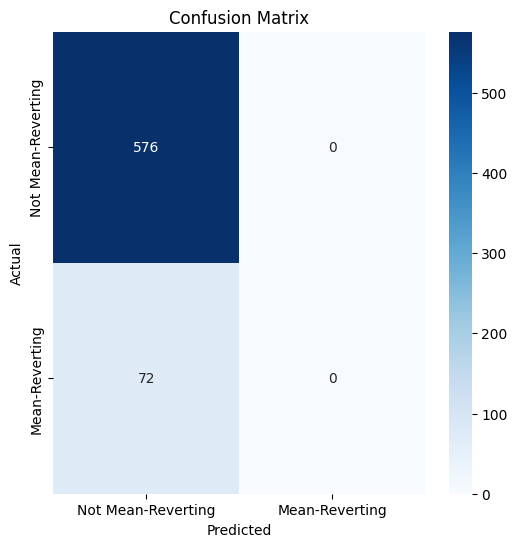

/tmp/ipykernel_354/397029394.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_coefficients, y=sorted_features, palette="viridis")


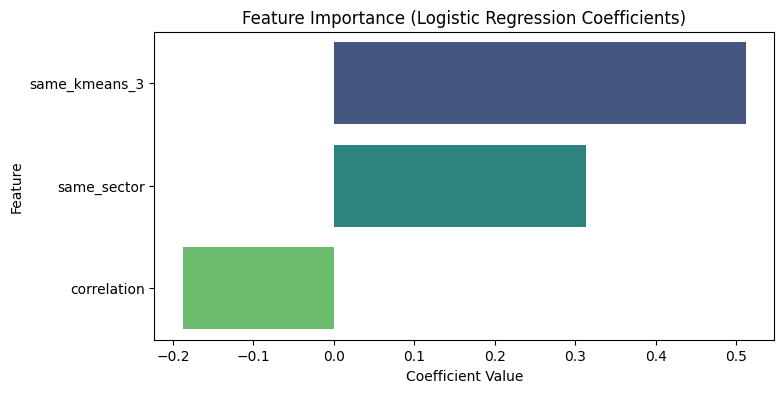

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# confusion matrix
cm = confusion_matrix(y_simp_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Mean-Reverting", "Mean-Reverting"], 
            yticklabels=["Not Mean-Reverting", "Mean-Reverting"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# feature importance
feature_names = X.columns
coefficients = log_reg.coef_.flatten()

sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = feature_names[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

plt.figure(figsize=(8, 4))
sns.barplot(x=sorted_coefficients, y=sorted_features, palette="viridis")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

### Gradient Boosting

#### 3 features

In [171]:
classification_df_3 = simplified_df

In [172]:
# train/test split

X_3 = classification_df_3.drop(columns=['pair', 'mean_reverting'])
y_3 = classification_df_3['mean_reverting']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

In [173]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

model_3 = GradientBoostingClassifier(random_state=42)
model_3.fit(X_train_3, y_train_3)

GradientBoostingClassifier(random_state=42)

In [174]:
from xgboost import XGBClassifier

model_3 = XGBClassifier(scale_pos_weight=len(y_train_3[y_train_3 == False]) / len(y_train_3[y_train_3 == True]))
model_3.fit(X_train_3, y_train_3)
y_pred_3 = model_3.predict(X_test_3)
y_proba_3 = model_3.predict_proba(X_test_3)[:, 1]

print(classification_report(y_test_3, y_pred_3))
print("ROC-AUC Score:", roc_auc_score(y_test_3, y_proba_3))

              precision    recall  f1-score   support

       False       0.92      0.75      0.82       576
        True       0.19      0.47      0.27        72

    accuracy                           0.72       648
   macro avg       0.55      0.61      0.55       648
weighted avg       0.84      0.72      0.76       648

ROC-AUC Score: 0.6219015239197531


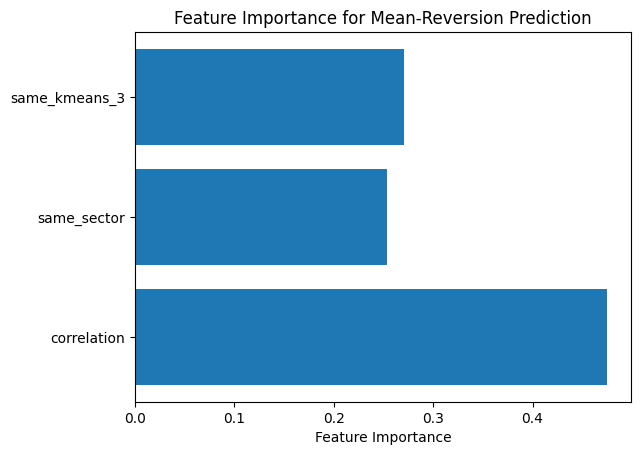

,Feature,Importance
0,correlation,0.475
1,same_sector,0.254
2,same_kmeans_3,0.271


In [176]:
# feature importance
importance_3 = model_3.feature_importances_
plt.barh(X_train_3.columns, importance_3)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Mean-Reversion Prediction')
plt.show()

feature_importance_3 = pd.DataFrame({
    'Feature': X_3.columns,
    'Importance': importance_3
})
feature_importance_3

#### 5 features

In [180]:
classification_df_5 = classification_df.drop(columns=['same_kmeans_6'])
classification_df_5.head()

,pair,correlation,same_sector,same_kmeans_3,mean_reverting,keyword_overlap,growth_diff
0,"(LLY, UNH)",0.893,0,1,False,30,-0.003
1,"(LLY, JNJ)",0.796,1,0,False,29,0.036
2,"(LLY, ABBV)",0.901,1,1,False,31,0.018
3,"(LLY, MRK)",0.911,1,0,False,32,-0.005
4,"(LLY, ABT)",0.745,0,0,False,27,0.020


In [181]:
# train/test split

X_5 = classification_df_5.drop(columns=['pair', 'mean_reverting'])
y_5 = classification_df_5['mean_reverting']
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42)

In [182]:
from xgboost import XGBClassifier

model_5 = XGBClassifier(scale_pos_weight=len(y_train_5[y_train_5 == False]) / len(y_train_5[y_train_5 == True]))
model_5.fit(X_train_5, y_train_5)
y_pred_5 = model_5.predict(X_test_5)
y_proba_5 = model_5.predict_proba(X_test_5)[:, 1]

print(classification_report(y_test_5, y_pred_5))
print("ROC-AUC Score:", roc_auc_score(y_test_5, y_proba_5))

              precision    recall  f1-score   support

       False       0.93      0.91      0.92       576
        True       0.38      0.43      0.41        72

    accuracy                           0.86       648
   macro avg       0.66      0.67      0.66       648
weighted avg       0.87      0.86      0.86       648

ROC-AUC Score: 0.7062596450617283


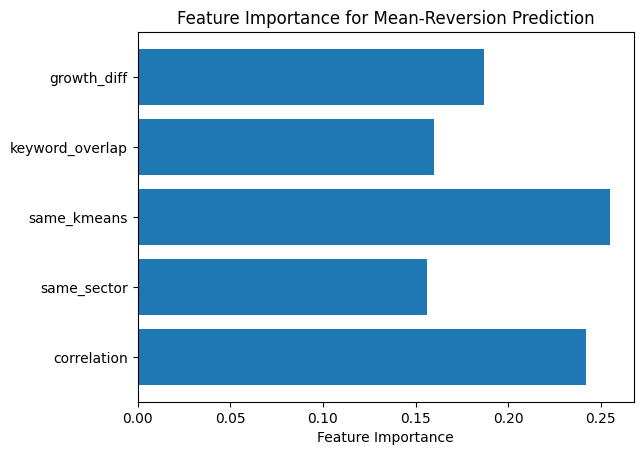

,Feature,Importance
0,correlation,0.242
1,same_sector,0.156
2,same_kmeans,0.255
3,keyword_overlap,0.160
4,growth_diff,0.187


In [132]:
importance_5 = model_5.feature_importances_
plt.barh(X_train_5.columns, importance_5)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Mean-Reversion Prediction')
plt.show()

feature_importance_5 = pd.DataFrame({
    'Feature': X_5.columns,
    'Importance': importance_5
})
feature_importance_5

### KMeans with 6 clusters

In [186]:
# c = 6 for clusters
# train/test split
from sklearn.model_selection import train_test_split

classification_df_6 = classification_df.drop(columns=['same_kmeans_3'])
X_6 = classification_df_6.drop(columns=['pair', 'mean_reverting'])
y_6 = classification_df_6['mean_reverting']

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_6, y_6, test_size=0.2, random_state=42)

In [187]:
from xgboost import XGBClassifier

model_6 = XGBClassifier(scale_pos_weight=len(y_train_6[y_train_6 == False]) / len(y_train_6[y_train_6 == True]))
model_6.fit(X_train_6, y_train_6)
y_pred_6 = model_6.predict(X_test_6)
y_proba_6 = model_6.predict_proba(X_test_6)[:, 1]

# Evaluate
print(classification_report(y_test_6, y_pred_6))
print("ROC-AUC Score:", roc_auc_score(y_test_6, y_proba_6))

              precision    recall  f1-score   support

       False       0.92      0.91      0.92       576
        True       0.35      0.36      0.35        72

    accuracy                           0.85       648
   macro avg       0.63      0.64      0.64       648
weighted avg       0.86      0.85      0.85       648

ROC-AUC Score: 0.6910325038580247


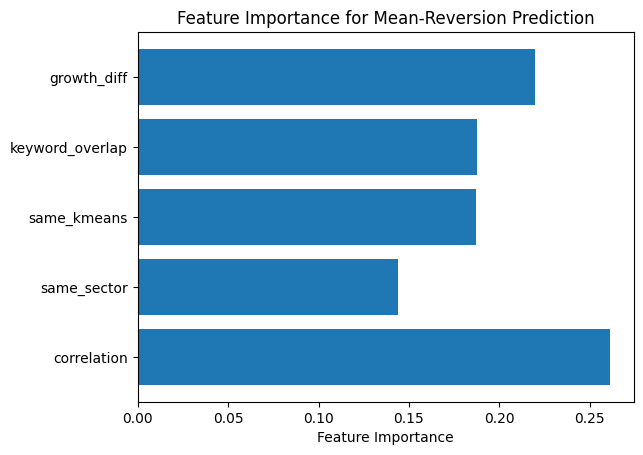

,Feature,Importance
0,correlation,0.261
1,same_sector,0.144
2,same_kmeans,0.187
3,keyword_overlap,0.188
4,growth_diff,0.220


In [70]:
import matplotlib.pyplot as plt

# Feature importance plot
importance_6 = model_6.feature_importances_
plt.barh(X_train_6.columns, importance_6)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Mean-Reversion Prediction')
plt.show()

feature_importance_6 = pd.DataFrame({
    'Feature': X_6.columns,
    'Importance': importance_6
})
feature_importance_6

### Gradient Boosting Classifier with 5 Features

In [188]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

model_5GB = GradientBoostingClassifier(random_state=42)
model_5GB.fit(X_train_5, y_train_5)

GradientBoostingClassifier(random_state=42)

In [189]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_5GB = model_5GB.predict(X_test_5)
y_proba_5GB = model_5GB.predict_proba(X_test_5)[:, 1]

print(classification_report(y_test_5, y_pred_5GB))
print("ROC-AUC Score:", roc_auc_score(y_test_5, y_proba_5GB))

              precision    recall  f1-score   support

       False       0.91      0.99      0.94       576
        True       0.62      0.18      0.28        72

    accuracy                           0.90       648
   macro avg       0.76      0.58      0.61       648
weighted avg       0.87      0.90      0.87       648

ROC-AUC Score: 0.7570047260802469


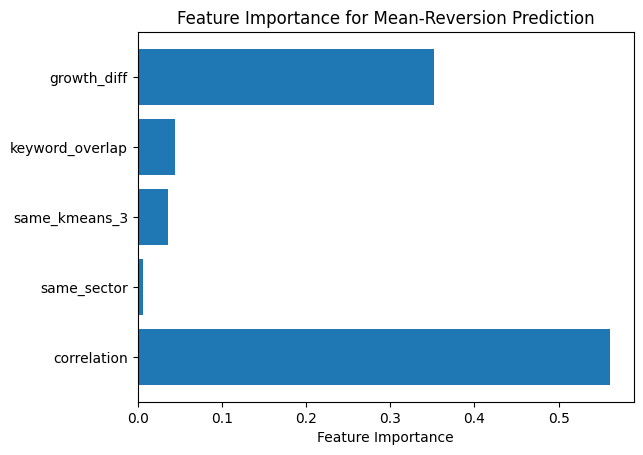

,Feature,Importance
0,correlation,0.561
1,same_sector,0.006
2,same_kmeans_3,0.036
3,keyword_overlap,0.045
4,growth_diff,0.352


In [191]:
importance_5GB = model_5GB.feature_importances_
plt.barh(X_train_5.columns, importance_5GB)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Mean-Reversion Prediction')
plt.show()

feature_importance_5GB = pd.DataFrame({
    'Feature': X_5.columns,
    'Importance': importance_5GB
})
feature_importance_5GB

### Addressing Class Imbalance

In [196]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# downsample the majority class
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train_5, y_train_5)
model_downsampled = RandomForestClassifier(random_state=42)
model_downsampled.fit(X_resampled, y_resampled)

y_pred_downsampled = model_downsampled.predict(X_test_5)
y_prob_downsampled = model_downsampled.predict_proba(X_test_5)[:, 1]

print("Downsampling Results")
print(classification_report(y_test_5, y_pred_downsampled))
print(f"ROC-AUC Score: {roc_auc_score(y_test_5, y_prob_downsampled):.3f}")

# upweight the minority class
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([False, True])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_5)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

model_upweighted = RandomForestClassifier(random_state=42
                                 #, class_weight=class_weights_dict
                                )
model_upweighted.fit(X_train_5, y_train_5)

# Evaluate the model
y_pred_upweighted = model_upweighted.predict(X_test_5)
y_prob_upweighted = model_upweighted.predict_proba(X_test_5)[:, 1]

print("Upweighting Results")
print(classification_report(y_test_5, y_pred_upweighted))
print(f"ROC-AUC Score: {roc_auc_score(y_test_5, y_prob_upweighted):.3f}")

# Combine Downsampling and Upweighting
X_resampled, y_resampled = undersampler.fit_resample(X_train_5, y_train_5)

model_combined = RandomForestClassifier(random_state=42
                               #, class_weight=class_weights_dict
                              )
model_combined.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred_combined = model_combined.predict(X_test_5)
y_prob_combined = model_combined.predict_proba(X_test_5)[:, 1]

print("Combined Downsampling and Upweighting Results")
print(classification_report(y_test_5, y_pred_combined))
print(f"ROC-AUC Score: {roc_auc_score(y_test_5, y_prob_combined):.3f}")

Downsampling Results
              precision    recall  f1-score   support

       False       0.94      0.68      0.79       576
        True       0.20      0.62      0.30        72

    accuracy                           0.67       648
   macro avg       0.57      0.65      0.54       648
weighted avg       0.85      0.67      0.73       648

ROC-AUC Score: 0.724
Upweighting Results
              precision    recall  f1-score   support

       False       0.91      0.99      0.95       576
        True       0.73      0.22      0.34        72

    accuracy                           0.90       648
   macro avg       0.82      0.61      0.64       648
weighted avg       0.89      0.90      0.88       648

ROC-AUC Score: 0.727
Combined Downsampling and Upweighting Results
              precision    recall  f1-score   support

       False       0.94      0.68      0.79       576
        True       0.20      0.62      0.30        72

    accuracy                           0.67       648

In [197]:
results = []

# Downsampling
downsampling_report = classification_report(y_test_5, y_pred_downsampled, output_dict=True)
downsampling_auc = roc_auc_score(y_test_5, y_prob_downsampled)
results.append({
    'Method': 'Downsampling',
    'Precision': downsampling_report['True']['precision'],
    'Recall': downsampling_report['True']['recall'],
    'F1-Score': downsampling_report['True']['f1-score'],
    'Support': downsampling_report['True']['support'],
    'ROC-AUC': downsampling_auc
})

# Upweighting
upweighting_report = classification_report(y_test_5, y_pred_upweighted, output_dict=True)
upweighting_auc = roc_auc_score(y_test_5, y_prob_upweighted)
results.append({
    'Method': 'Upweighting',
    'Precision': upweighting_report['True']['precision'],
    'Recall': upweighting_report['True']['recall'],
    'F1-Score': upweighting_report['True']['f1-score'],
    'Support': upweighting_report['True']['support'],
    'ROC-AUC': upweighting_auc
})

# Combined Downsampling and Upweighting
combined_report = classification_report(y_test_5, y_pred_combined, output_dict=True)
combined_auc = roc_auc_score(y_test_5, y_prob_combined)
results.append({
    'Method': 'Both',
    'Precision': combined_report['True']['precision'],
    'Recall': combined_report['True']['recall'],
    'F1-Score': combined_report['True']['f1-score'],
    'Support': combined_report['True']['support'],
    'ROC-AUC': combined_auc
})

results_df = pd.DataFrame(results)
results_df

,Method,Precision,Recall,F1-Score,Support,ROC-AUC
0,Downsampling,0.196,0.625,0.298,72.0,0.724
1,Upweighting,0.727,0.222,0.340,72.0,0.727
2,Both,0.196,0.625,0.298,72.0,0.724
